In [1]:
from src.rejax.envs.bernoulli_bandit import BernoulliBandit, EnvParams
from rejax import get_algo
from rejax.evaluate import evaluate

import jax
import jax.numpy as jnp
import numpy as np
import yaml

In [2]:
config_path = "/Users/chanb/research/ualberta/sandbox/rejax/configs/custom/bandit.yaml"

with open(config_path, "r") as f:
    config = yaml.safe_load(f.read())

In [3]:
algo_name = "ucb"
seed_id = 0
num_seeds = 10
num_arms = 2

key = jax.random.PRNGKey(seed_id)
keys = jax.random.split(key, num_seeds)
config = config[algo_name]

In [4]:
config

{'agent_kwargs': {'confidence': 1.0},
 'total_timesteps': 100000,
 'eval_freq': 1000}

In [5]:
env = BernoulliBandit()
config["env"] = env

env_params = jax.random.uniform(key, shape=(num_seeds, num_arms))

algo_cls = get_algo(algo_name)
algo = jax.vmap(lambda x: algo_cls.create(**config))(env_params)
algo = algo.replace(
    env_params=algo.env_params.replace(reward_probs=env_params)
)


def eval_callback(algo, ts, rng):
    act = algo.make_act(ts)
    max_steps = algo.env_params.max_steps_in_episode
    return evaluate(act, rng, env, algo.env_params, 128, max_steps)

algo = algo.replace(
    eval_callback=eval_callback
)

In [6]:
algo

UCB(env=<src.rejax.envs.bernoulli_bandit.BernoulliBandit object at 0x136f7d6c0>, env_params=EnvParams(max_steps_in_episode=Array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32, weak_type=True), reward_probs=Array([[0.947667  , 0.9785799 ],
       [0.33229148, 0.46866846],
       [0.5698887 , 0.16550303],
       [0.3101946 , 0.68948054],
       [0.74676657, 0.17101455],
       [0.9853538 , 0.02528262],
       [0.6400418 , 0.56269085],
       [0.8992138 , 0.93453753],
       [0.8341402 , 0.7256162 ],
       [0.5098531 , 0.02765214]], dtype=float32)), eval_callback=<function eval_callback at 0x136cf7c70>, eval_freq=1000, skip_initial_evaluation=False, total_timesteps=100000, learning_rate=Array([0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
       0.0003, 0.0003], dtype=float32, weak_type=True), gamma=Array([0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99],      dtype=float32, weak_type=True), max_grad_norm=Array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]

In [7]:
vmap_train = jax.jit(jax.vmap(algo_cls.train, in_axes=(0, 0)))
ts, (_, returns) = vmap_train(algo, keys)
returns.block_until_ready()

{'params': {'counts': Traced<float32[1,2]>with<DynamicJaxprTrace>, 'q_values': Traced<float32[1,2]>with<DynamicJaxprTrace>, 'timesteps': Traced<float32[]>with<DynamicJaxprTrace>}}


Array([[[1., 1., 1., ..., 1., 0., 1.],
        [0., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 0., 1.],
        [1., 0., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[0., 1., 0., ..., 0., 0., 1.],
        [1., 0., 0., ..., 1., 0., 0.],
        [1., 0., 1., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 1.],
        [0., 1., 0., ..., 1., 1., 1.],
        [1., 1., 0., ..., 1., 0., 0.]],

       [[0., 0., 1., ..., 1., 0., 0.],
        [1., 1., 1., ..., 1., 0., 1.],
        [1., 0., 1., ..., 0., 1., 0.],
        ...,
        [0., 1., 1., ..., 0., 1., 1.],
        [1., 1., 0., ..., 1., 0., 1.],
        [0., 0., 0., ..., 1., 1., 1.]],

       ...,

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [0., 1., 1., ..., 1., 1.

In [8]:
jax.vmap(lambda x: jax.numpy.mean(x))(returns)

Array([0.97362316, 0.46797648, 0.56706375, 0.68866026, 0.7428063 ,
       0.9861541 , 0.6334313 , 0.9327815 , 0.83330756, 0.50293934],      dtype=float32)

In [12]:
env_params

Array([[0.947667  , 0.9785799 ],
       [0.33229148, 0.46866846],
       [0.5698887 , 0.16550303],
       [0.3101946 , 0.68948054],
       [0.74676657, 0.17101455],
       [0.9853538 , 0.02528262],
       [0.6400418 , 0.56269085],
       [0.8992138 , 0.93453753],
       [0.8341402 , 0.7256162 ],
       [0.5098531 , 0.02765214]], dtype=float32)

In [10]:
jax.debug.print("{x}", x=ts.agent_ts.params)

{'params': {'counts': Array([[[1.0095e+04, 8.9905e+04]],

       [[1.3430e+03, 9.8657e+04]],

       [[9.9844e+04, 1.5600e+02]],

       [[1.9800e+02, 9.9802e+04]],

       [[9.9953e+04, 4.7000e+01]],

       [[9.9976e+04, 2.4000e+01]],

       [[9.7539e+04, 2.4610e+03]],

       [[9.7410e+03, 9.0259e+04]],

       [[9.8169e+04, 1.8310e+03]],

       [[9.9909e+04, 9.1000e+01]]], dtype=float32), 'q_values': Array([[[0.94710255, 0.9788683 ]],

       [[0.35219657, 0.46802562]],

       [[0.57004964, 0.19871794]],

       [[0.36363634, 0.69227916]],

       [[0.7487634 , 0.0638298 ]],

       [[0.9851631 , 0.        ]],

       [[0.6409308 , 0.5595286 ]],

       [[0.9015506 , 0.93427163]],

       [[0.83472914, 0.7378477 ]],

       [[0.5125064 , 0.02197802]]], dtype=float32), 'timesteps': Array([100000., 100000., 100000., 100000., 100000., 100000., 100000.,
       100000., 100000., 100000.], dtype=float32)}}


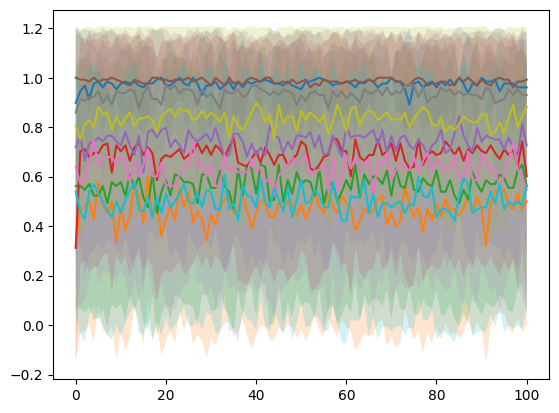

In [11]:
import matplotlib.pyplot as plt

for env_returns in returns:
    xrange = np.arange(len(env_returns))
    mean = np.mean(env_returns, axis=-1)
    std = np.std(env_returns, axis=-1)
    plt.plot(xrange, mean)
    plt.fill_between(xrange, mean - std, mean + std, alpha=0.2)
plt.show()
